# Análisis de Volumen de compra

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, chisquare
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning

sns.set_theme(style='whitegrid')
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')


In [2]:
DATA_ROOTS = [Path('outputs_teóricos'), Path('outputs_teoricos')]


def discover_customer_files(roots):
    files = []
    for root in roots:
        if not root.exists():
            continue
        files.extend(sorted(root.glob('Week-*-Day-*/customers.csv')))
    return files


def infer_day_type_from_folder(path: Path) -> str:
    text = str(path)
    if 'Day-07' in text:
        return 'Tipo 3'
    if any(tag in text for tag in ('Day-03', 'Day-05', 'Day-06')):
        return 'Tipo 2'
    return 'Tipo 1'


def load_items_dataset(files):
    frames = []
    for csv_path in files:
        try:
            df = pd.read_csv(csv_path, usecols=['profile', 'priority', 'payment_method', 'items'])
        except ValueError as exc:
            print(f"[WARN] {csv_path} omitido ({exc})")
            continue
        if df.empty:
            continue
        df['source_folder'] = csv_path.parent.name
        df['day_type'] = infer_day_type_from_folder(csv_path)
        frames.append(df)

    if not frames:
        raise RuntimeError('No se pudieron cargar registros desde outputs teóricos.')

    data = pd.concat(frames, ignore_index=True)
    data['profile'] = data['profile'].astype(str).str.strip().str.lower().str.replace(r'^customerprofile\.', '', regex=True)
    data['priority'] = data['priority'].astype(str).str.strip().str.lower()
    data['payment_method'] = data['payment_method'].astype(str).str.strip().str.lower()
    data['day_type'] = data['day_type'].astype(str).str.strip()
    data['items'] = pd.to_numeric(data['items'], errors='coerce')
    data = data.dropna(subset=['items'])
    data['items'] = data['items'].astype(int)
    return data

In [3]:
customer_files = discover_customer_files(DATA_ROOTS)
print(f'Archivos detectados: {len(customer_files)}')
items_df = load_items_dataset(customer_files)
print(f'Registros cargados: {items_df.shape[0]:,}')
items_df.head()

Archivos detectados: 364
Registros cargados: 1,456,663


,profile,priority,items,payment_method,source_folder,day_type
0,regular,no_priority,12,card,Week-1-Day-1,Tipo 1
1,regular,no_priority,25,card,Week-1-Day-1,Tipo 1
2,express_basket,no_priority,13,card,Week-1-Day-1,Tipo 1
3,family_cart,no_priority,78,cash,Week-1-Day-1,Tipo 1
4,express_basket,no_priority,1,card,Week-1-Day-1,Tipo 1


In [4]:
def poisson_chisquare_test(sample: pd.Series, min_expected: float = 5.0):
    values = sample.to_numpy()
    n = values.size
    if n == 0:
        return np.nan, np.nan
    if np.all(values == values[0]):
        return np.nan, np.nan

    lam = values.mean()
    support = np.arange(0, values.max() + 1)
    observed = np.array([(values == s).sum() for s in support], dtype=float)

    expected_probs = poisson.pmf(support, lam)
    tail_prob = 1 - poisson.cdf(support[-1], lam)
    expected_probs[-1] += tail_prob
    expected = expected_probs * n

    mask = expected > 0
    observed = observed[mask]
    expected = expected[mask]

    obs = observed.copy()
    exp = expected.copy()
    while exp.size > 1 and exp.min() < min_expected:
        idx = exp.argmin()
        if idx == 0:
            exp[1] += exp[0]
            obs[1] += obs[0]
            exp = exp[1:]
            obs = obs[1:]
        else:
            exp[idx - 1] += exp[idx]
            obs[idx - 1] += obs[idx]
            exp = np.delete(exp, idx)
            obs = np.delete(obs, idx)

    if exp.size <= 1:
        return np.nan, np.nan

    chi_stat, pvalue = chisquare(obs, f_exp=exp)
    return float(chi_stat), float(pvalue)


DEFAULT_KDE_KERNELS = ['gaussian', 'epanechnikov', 'exponential', 'linear', 'tophat']
DEFAULT_KDE_BANDWIDTHS = np.geomspace(0.05, 1.0, 10)


def select_kde_distribution(sample: pd.Series,
                            kernels=None,
                            bandwidths=None) -> tuple[np.ndarray, np.ndarray, str, float]:
    x = np.asarray(sample, dtype=float)
    if x.size < 2:
        raise ValueError('Muestra insuficiente para KDE')
    if x.min() < 0:
        raise ValueError('items debe ser ≥ 0')
    if np.allclose(x, x[0]):
        raise ValueError('Sin variación en la muestra')

    kernels = kernels or DEFAULT_KDE_KERNELS
    bandwidths = bandwidths or DEFAULT_KDE_BANDWIDTHS

    log_x = np.log1p(x)[:, None]
    cv_folds = min(5, log_x.shape[0])
    if cv_folds < 2:
        raise ValueError('No hay suficientes datos para validar KDE')

    grid = GridSearchCV(
        KernelDensity(kernel='gaussian'),
        param_grid={'kernel': kernels, 'bandwidth': bandwidths},
        cv=cv_folds,
        n_jobs=1
    )
    grid.fit(log_x)
    kde: KernelDensity = grid.best_estimator_
    best_kernel = grid.best_params_['kernel']
    best_bandwidth = float(grid.best_params_['bandwidth'])

    support_min = int(x.min())
    support_max = int(np.ceil(np.percentile(x, 99.5))) + 5
    support_max = max(support_max, int(x.max()))
    support = np.arange(support_min, support_max + 1)

    log_support = np.log1p(support)[:, None]
    log_pdf = kde.score_samples(log_support)
    pdf = np.exp(log_pdf) / (support + 1)
    pdf = np.clip(pdf, 0, None)
    if not np.isfinite(pdf).all() or pdf.sum() <= 0:
        raise ValueError('KDE inválido')
    pmf = pdf / pdf.sum()
    return support.astype(int), pmf, best_kernel, best_bandwidth


def summarize_items(data: pd.DataFrame,
                    kde_kernels=None,
                    kde_bandwidths=None) -> pd.DataFrame:
    group_cols = ['profile', 'priority', 'payment_method', 'day_type']
    records: list[dict[str, object]] = []

    for keys, grp in data.groupby(group_cols):
        sample = grp['items']
        chi_stat, chi_pvalue = poisson_chisquare_test(sample)
        counts = sample.value_counts()
        pmf = (counts / counts.sum()).sort_values(ascending=False)
        pmf_top = ", ".join([f"{int(idx)}: {prob:.1%}" for idx, prob in pmf.head(5).items()])

        poisson_lambda = sample.mean()
        suggested = 'poisson' if (not np.isnan(chi_pvalue) and chi_pvalue >= 0.05) else 'kde'
        kde_kernel = None
        kde_bandwidth = np.nan
        payload: dict[str, object] = {}

        if suggested == 'kde':
            try:
                support, weights, kde_kernel, kde_bandwidth = select_kde_distribution(
                    sample, kernels=kde_kernels, bandwidths=kde_bandwidths
                )
                payload = {
                    'type': 'kde',
                    'kernel': kde_kernel,
                    'bandwidth': kde_bandwidth,
                    'grid': support.tolist(),
                    'weights': [float(w) for w in weights.tolist()],
                }
            except ValueError:
                suggested = 'empirical'

        if suggested == 'poisson':
            payload = {'type': 'poisson', 'lambda': float(poisson_lambda)}
        elif suggested == 'empirical':
            sorted_pmf = (counts / counts.sum()).sort_index()
            payload = {
                'type': 'empirical',
                'pmf': {int(idx): float(prob) for idx, prob in sorted_pmf.items()}
            }
            kde_kernel = None
            kde_bandwidth = np.nan

        rec = dict(zip(group_cols, keys))
        rec.update({
            'n_obs': int(sample.size),
            'mean_items': sample.mean(),
            'std_items': sample.std(ddof=1),
            'median_items': sample.median(),
            'min_items': int(sample.min()),
            'max_items': int(sample.max()),
            'mode_items': int(counts.idxmax()),
            'chi2_stat': chi_stat,
            'chi2_pvalue': chi_pvalue,
            'chi2_reject': bool(chi_pvalue < 0.05) if not np.isnan(chi_pvalue) else True,
            'suggested_distribution': suggested,
            'poisson_lambda': poisson_lambda if suggested == 'poisson' else np.nan,
            'kde_kernel': kde_kernel,
            'kde_bandwidth': kde_bandwidth if suggested == 'kde' else np.nan,
            'distribution_payload_json': json.dumps(payload, ensure_ascii=False),
            'pmf_top5': pmf_top,
        })
        records.append(rec)

    summary = pd.DataFrame(records)
    summary = summary.sort_values(group_cols).reset_index(drop=True)
    return summary


In [ ]:
items_summary = summarize_items(items_df)
print(f'Combinaciones analizadas: {items_summary.shape[0]}')
items_summary.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1146: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1146: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1146: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1146: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/Library/Frameworks/Pyth

In [ ]:
def plot_histograms_for_profile(data: pd.DataFrame, summary: pd.DataFrame, profile: str, max_cols: int = 3):
    subset_summary = summary[summary['profile'] == profile].copy()
    if subset_summary.empty:
        print(f'Sin datos para {profile}')
        return

    subset_summary = subset_summary.sort_values(['priority', 'payment_method', 'day_type']).reset_index(drop=True)
    combos = subset_summary[['priority', 'payment_method', 'day_type']].to_records(index=False)
    n = len(combos)
    cols = min(max_cols, max(1, n))
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), squeeze=False)
    axes = axes.flatten()

    for ax_idx, combo in enumerate(combos):
        priority, payment, day_type = combo
        ax = axes[ax_idx]
        mask = (
            (data['profile'] == profile)
            & (data['priority'] == priority)
            & (data['payment_method'] == payment)
            & (data['day_type'] == day_type)
        )
        sample = data.loc[mask, 'items']
        sns.histplot(sample, binwidth=1, stat='probability', color='#0C5DA5', edgecolor='black', ax=ax)

        row = subset_summary.iloc[ax_idx]
        payload = json.loads(row['distribution_payload_json']) if isinstance(row['distribution_payload_json'], str) else {}
        dist_type = payload.get('type', row['suggested_distribution'])
        label_text = dist_type.upper()

        if dist_type == 'poisson':
            lam = payload.get('lambda', row.get('poisson_lambda'))
            if lam is not None and not np.isnan(lam):
                support = np.arange(sample.min(), sample.max() + 1)
                probs = poisson.pmf(support, lam)
                if probs.sum() > 0:
                    probs = probs / probs.sum()
                    ax.step(support, probs, where='mid', color='#FF6B6B', label=f"Poisson λ={lam:.2f}")
                    label_text = f"Poisson (λ={lam:.2f})"
        elif dist_type == 'kde':
            grid = np.array(payload.get('grid', []), dtype=float)
            weights = np.array(payload.get('weights', []), dtype=float)
            kernel = payload.get('kernel', row.get('kde_kernel', 'gaussian'))
            bw = payload.get('bandwidth', row.get('kde_bandwidth', np.nan))
            if grid.size and weights.size:
                ax.step(grid, weights, where='mid', color='#FF6B6B', label=f"KDE {kernel}, bw={bw:.3f}")
                label_text = f"KDE ({kernel}, bw={bw:.3f})"
        else:
            pmf = payload.get('pmf', {})
            if pmf:
                support = np.array(sorted(pmf.keys()), dtype=float)
                weights = np.array([pmf[int(k)] for k in support], dtype=float)
                ax.step(support, weights, where='mid', color='#FF6B6B', label='PMF empírica')
                label_text = 'PMF empírica'

        ax.set_xlabel('Items')
        ax.set_ylabel('Probabilidad')
        pvalue = row['chi2_pvalue']
        pvalue_txt = f"{pvalue:.3f}" if not np.isnan(pvalue) else 'nan'
        ax.set_title(f"{priority} | {payment} | {day_type} n={int(row['n_obs'])}, p_chi2={pvalue_txt}")
        ax.text(0.02, 0.95, f"Distribución: {label_text}", transform=ax.transAxes, fontsize=9, va='top', ha='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        ax.legend(loc='upper right', fontsize=9)

    for ax in axes[n:]:
        ax.set_visible(False)

    fig.suptitle(f'Histograma de items - {profile}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


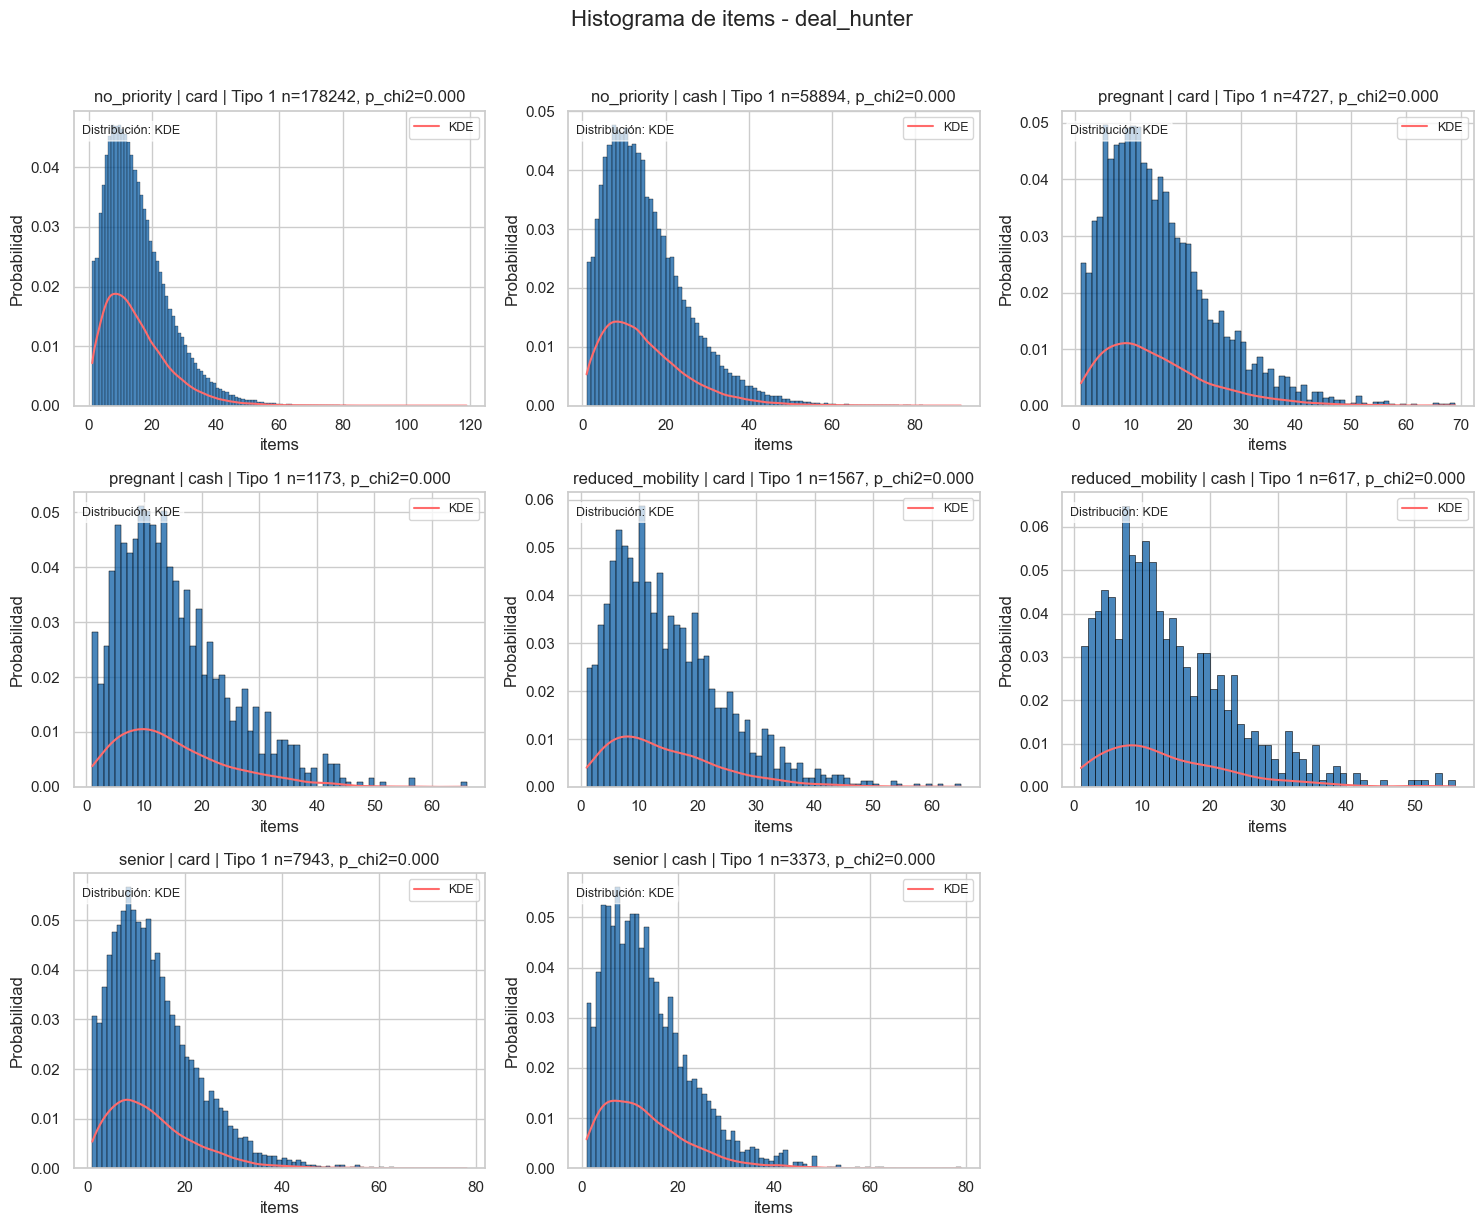

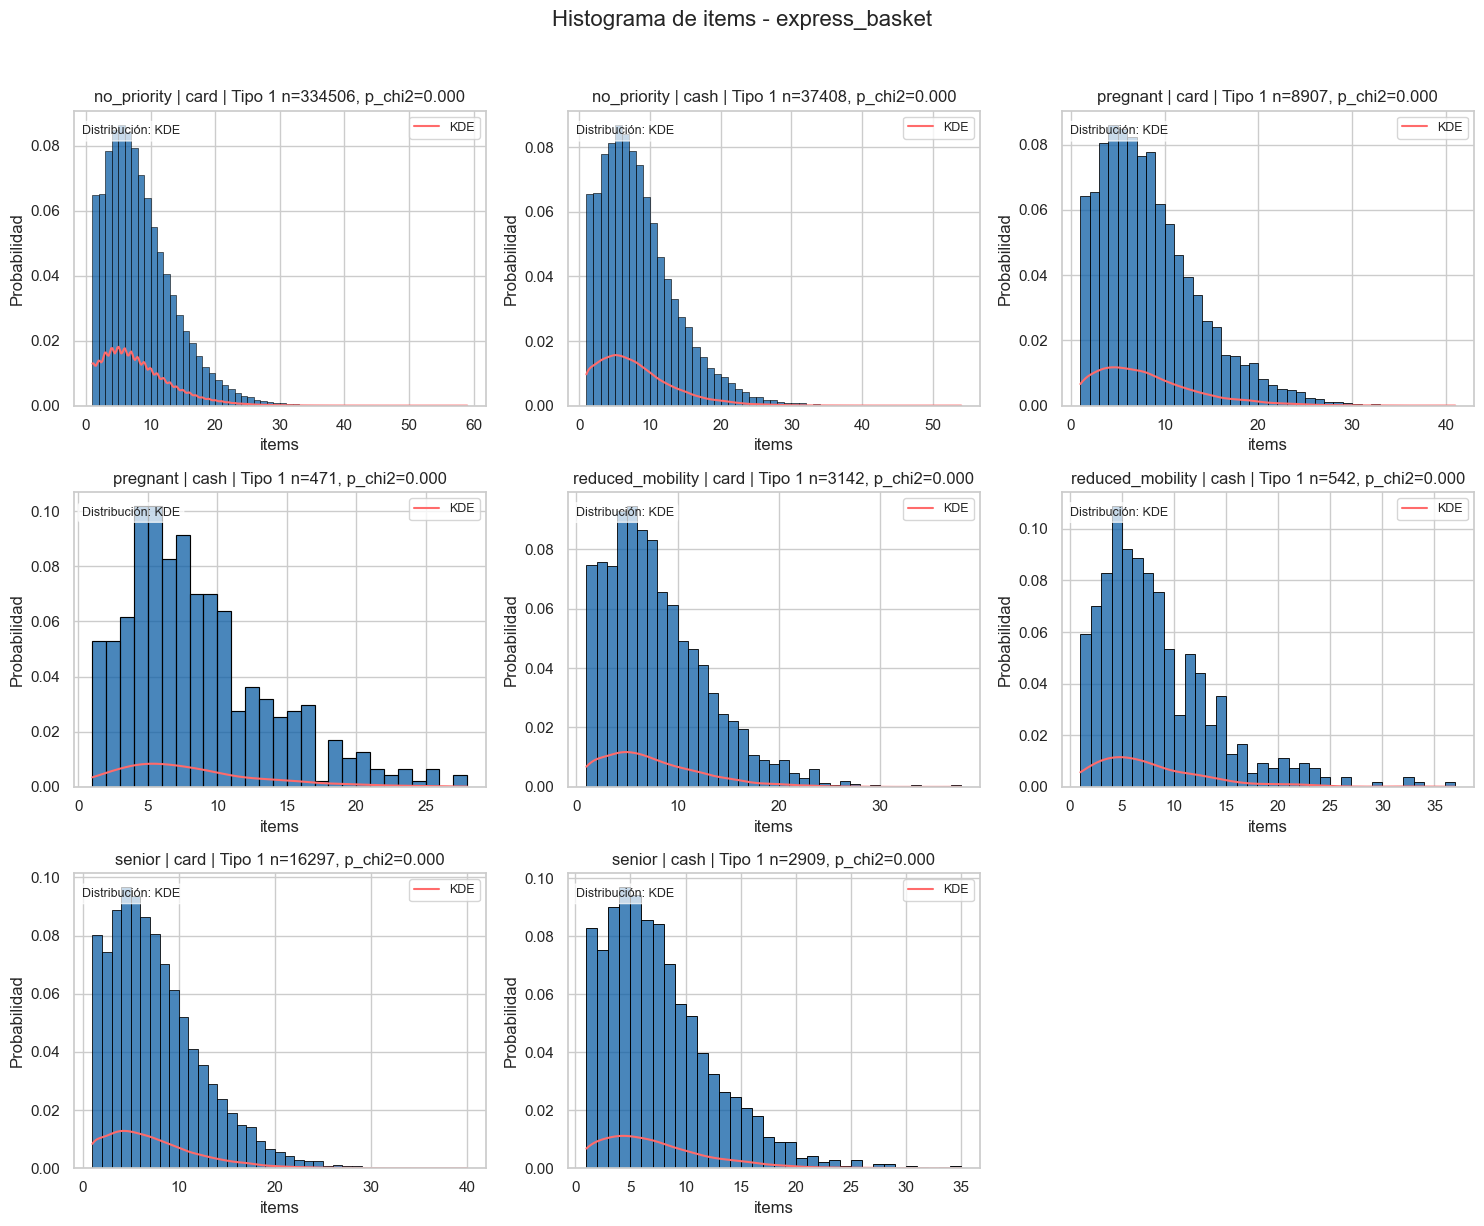

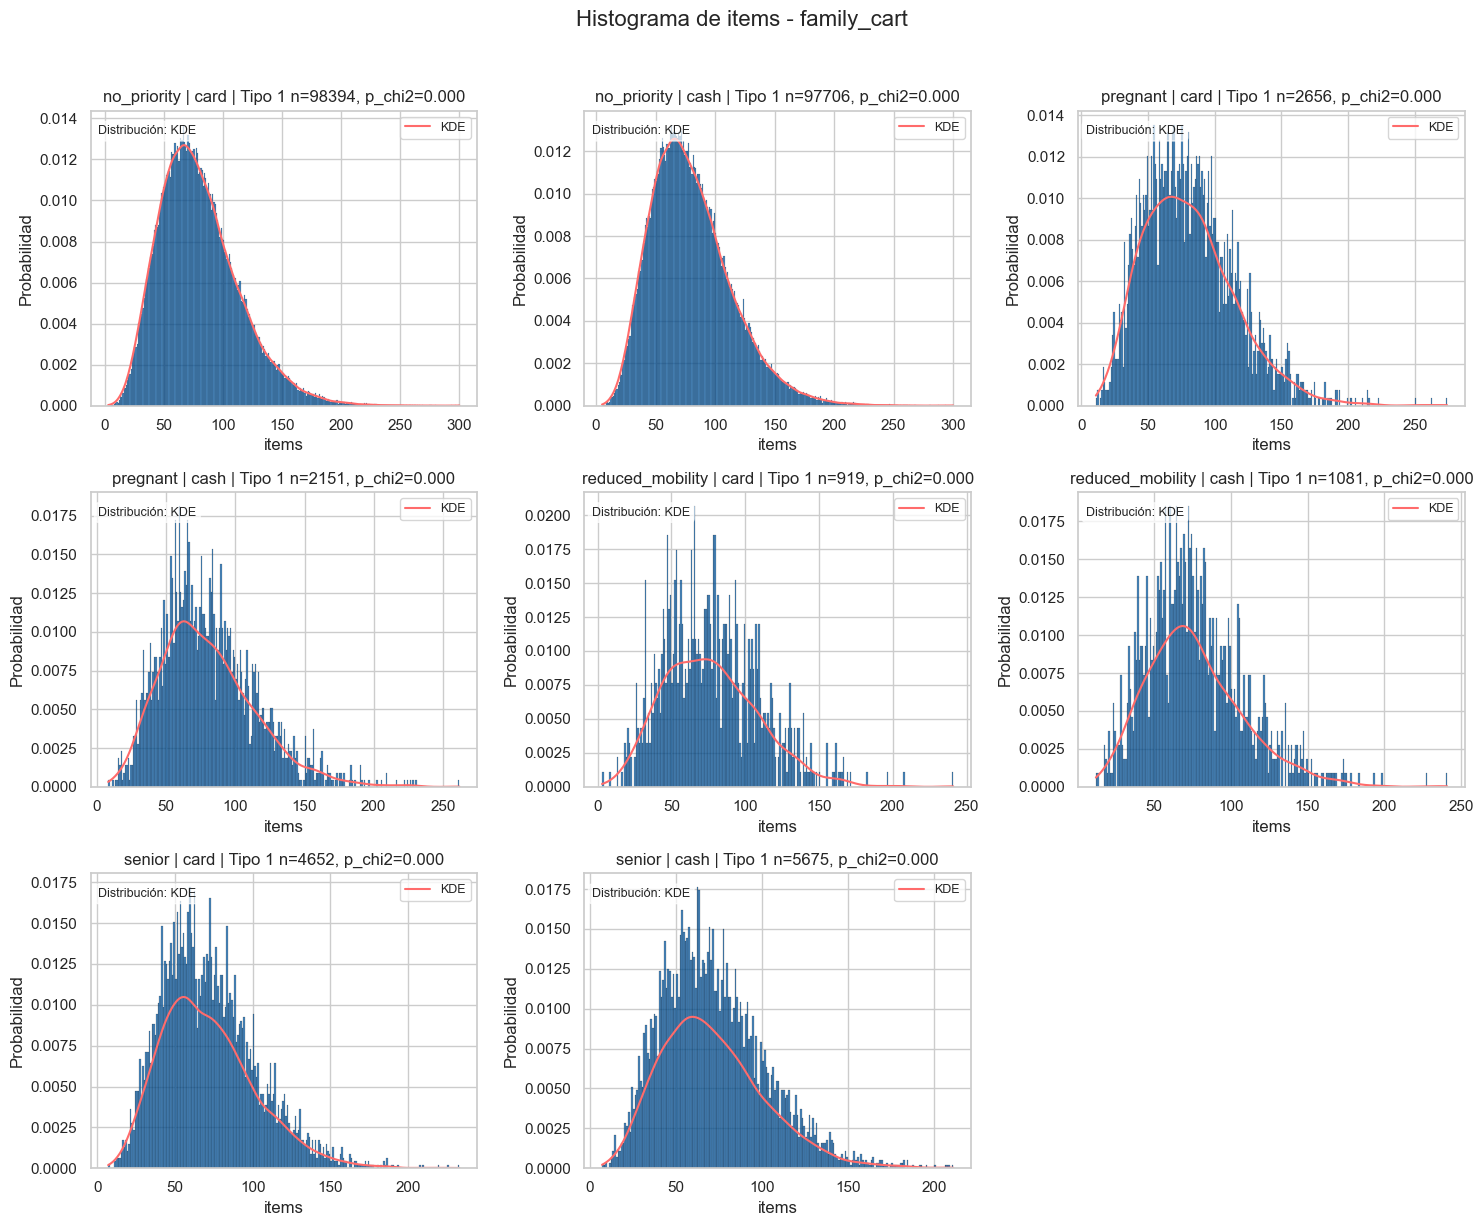

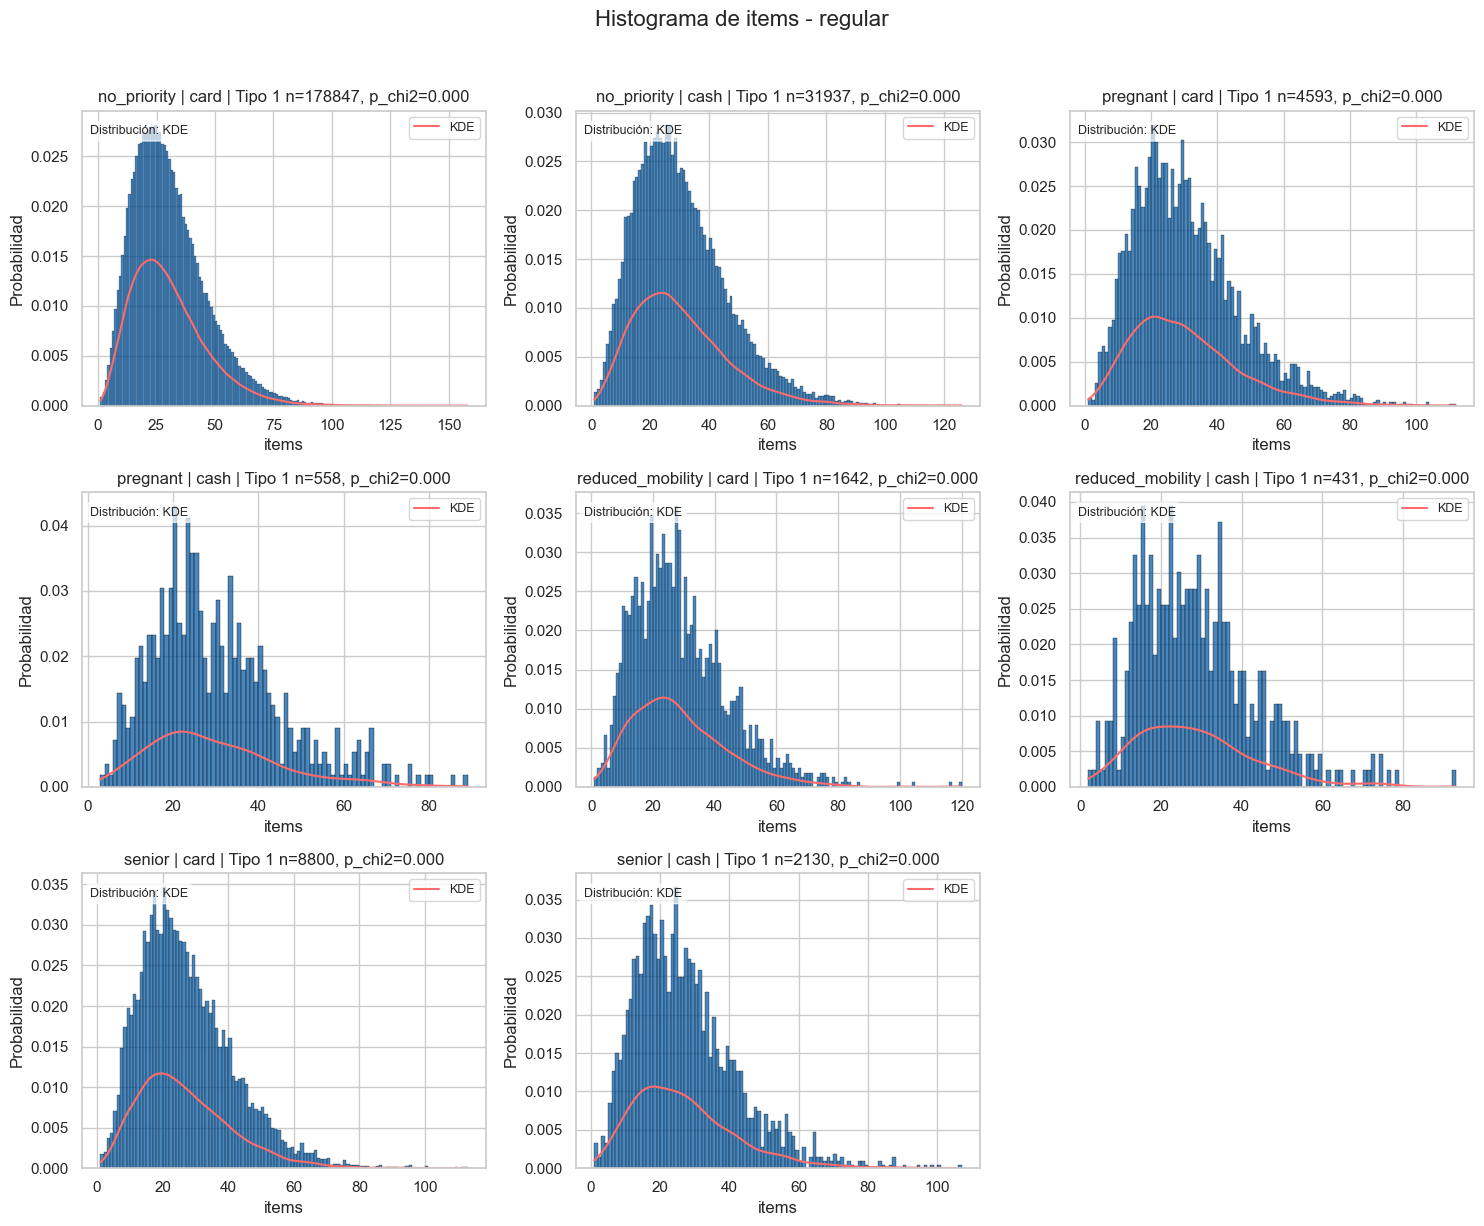

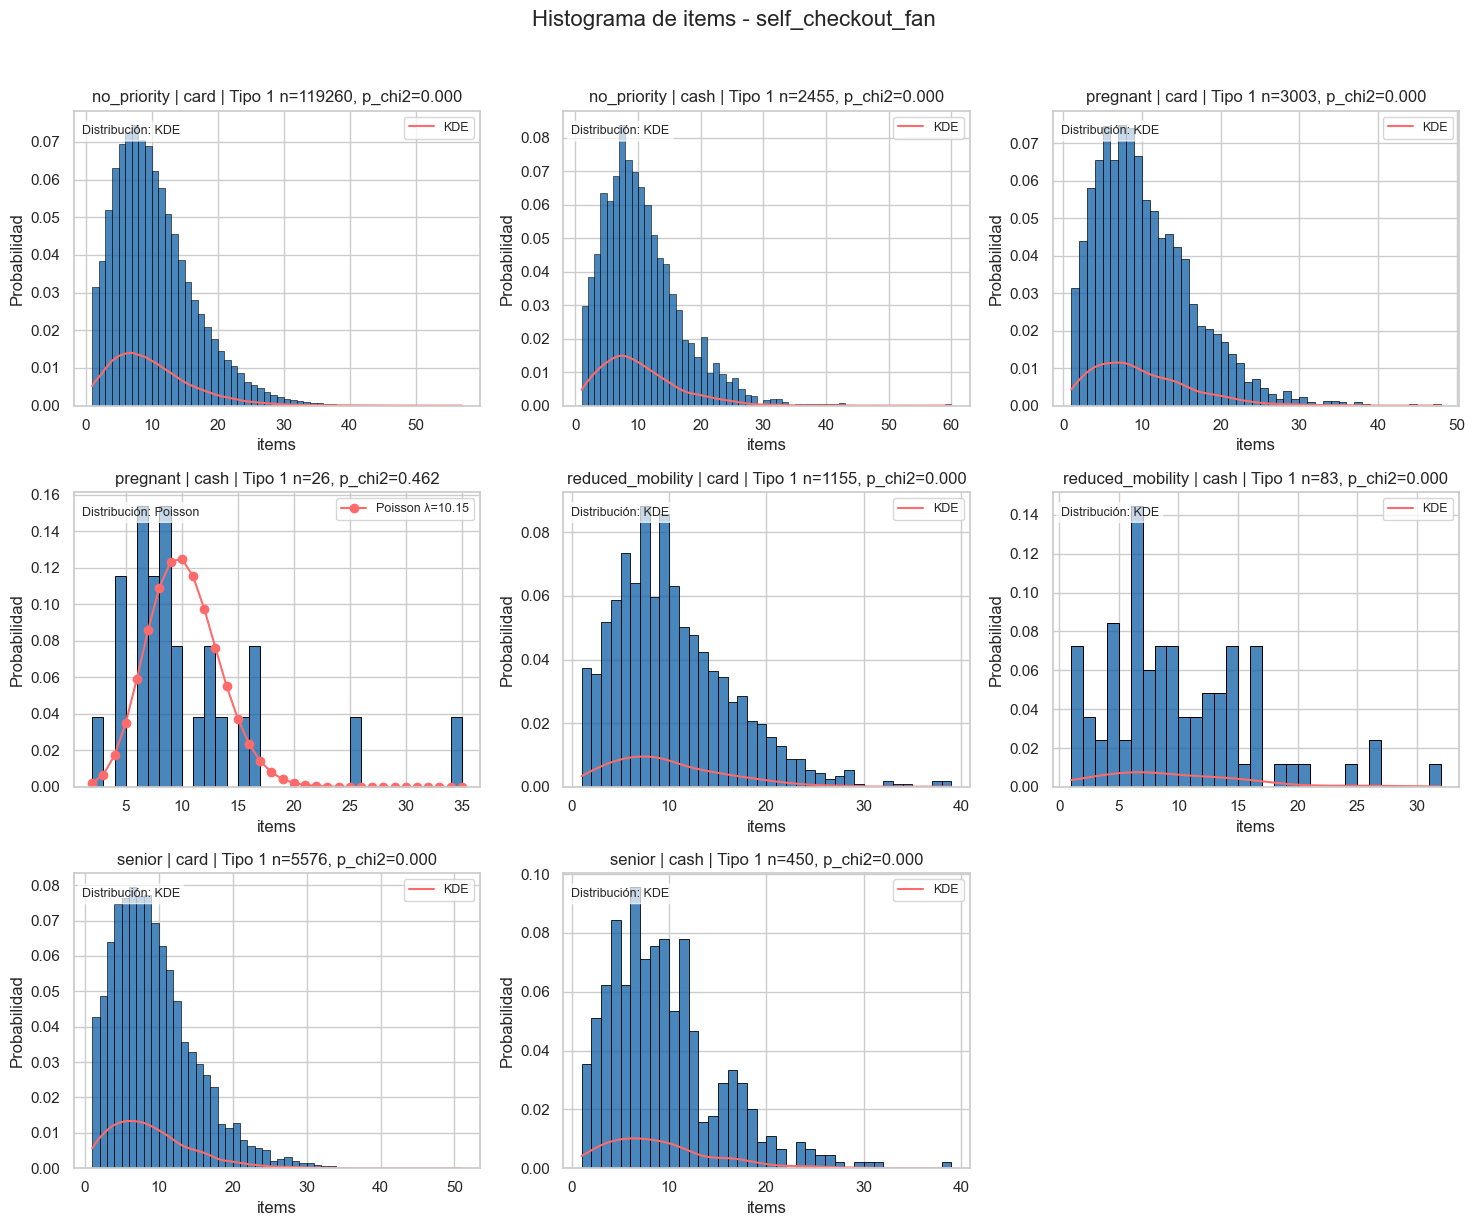

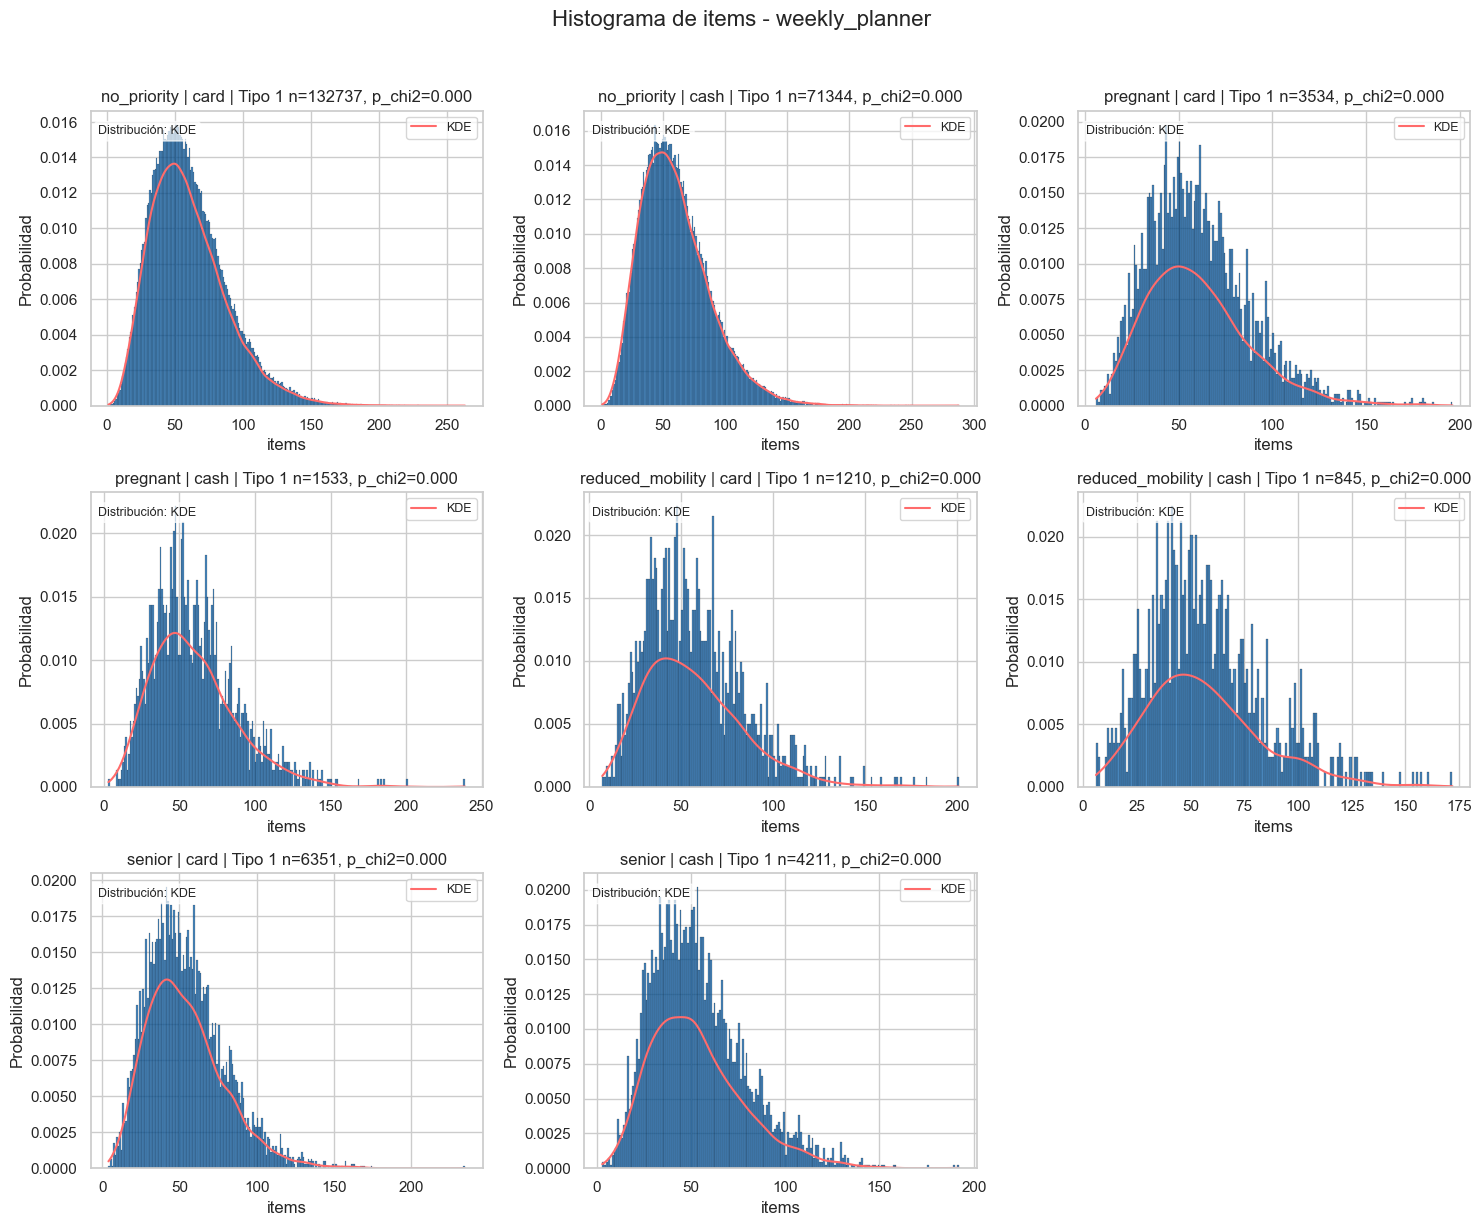

In [ ]:
for prof in sorted(items_summary['profile'].unique()):
    plot_histograms_for_profile(items_df, items_summary, prof)

In [ ]:
distribution_counts = (items_summary['suggested_distribution']
                        .value_counts()
                        .rename_axis('distribution')
                        .reset_index(name='n_groups'))
distribution_counts

,distribution,n_groups
0,kde,47
1,poisson,1


In [ ]:
simulator_cols = ['profile', 'priority', 'payment_method', 'day_type', 'n_obs', 'mean_items', 'std_items', 'median_items', 'mode_items', 'min_items', 'max_items', 'chi2_pvalue', 'suggested_distribution', 'poisson_lambda', 'kde_kernel', 'kde_bandwidth', 'distribution_payload_json', 'pmf_top5']
simulator_summary = items_summary[simulator_cols].copy()
simulator_summary.head(20)


,profile,priority,payment_method,day_type,n_obs,mean_items,std_items,median_items,mode_items,min_items,max_items,chi2_pvalue,suggested_distribution,poisson_lambda,kde_factor,distribution_payload_json,pmf_top5
0,deal_hunter,no_priority,card,Tipo 1,178242,15.00,10.23,13.00,9,1,119,0.00,kde,NaN,0.09,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","9: 4.7%, 7: 4.7%, 8: 4.7%, 10: 4.6%, 11: 4.6%"
1,deal_hunter,no_priority,cash,Tipo 1,58894,15.00,10.22,13.00,7,1,91,0.00,kde,NaN,0.11,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","7: 4.8%, 10: 4.7%, 8: 4.7%, 9: 4.6%, 12: 4.5%"
2,deal_hunter,pregnant,card,Tipo 1,4727,14.76,9.93,13.00,5,1,69,0.00,kde,NaN,0.18,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","5: 5.0%, 10: 5.0%, 11: 4.9%, 9: 4.9%, 8: 4.7%"
3,deal_hunter,pregnant,cash,Tipo 1,1173,14.86,9.83,13.00,9,1,66,0.00,kde,NaN,0.24,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","9: 5.1%, 10: 5.0%, 13: 5.0%, 11: 4.8%, 5: 4.8%"
4,deal_hunter,reduced_mobility,card,Tipo 1,1567,14.52,9.87,12.00,10,1,65,0.00,kde,NaN,0.23,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","10: 5.9%, 6: 5.4%, 7: 5.0%, 8: 4.8%, 5: 4.7%"
5,deal_hunter,reduced_mobility,cash,Tipo 1,617,13.59,9.62,11.00,7,1,56,0.00,kde,NaN,0.28,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","7: 6.5%, 10: 5.7%, 8: 5.3%, 9: 5.2%, 11: 5.2%"
6,deal_hunter,senior,card,Tipo 1,7943,13.37,8.99,12.00,8,1,78,0.00,kde,NaN,0.17,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","8: 5.7%, 9: 5.2%, 7: 5.2%, 12: 5.0%, 10: 5.0%"
7,deal_hunter,senior,cash,Tipo 1,3373,13.26,9.15,11.00,7,1,79,0.00,kde,NaN,0.20,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","7: 5.6%, 4: 5.2%, 5: 5.2%, 10: 5.1%, 11: 5.1%"
8,express_basket,no_priority,card,Tipo 1,334506,8.00,5.38,7.00,5,1,59,0.00,kde,NaN,0.08,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","5: 8.7%, 4: 8.5%, 6: 8.4%, 7: 7.9%, 3: 7.8%"
9,express_basket,no_priority,cash,Tipo 1,37408,8.00,5.40,7.00,5,1,54,0.00,kde,NaN,0.12,"{""grid"": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","5: 8.7%, 6: 8.4%, 4: 8.1%, 7: 7.9%, 3: 7.8%"


In [ ]:
output_path = Path('items_distribution_summary.csv')
simulator_summary.to_csv(output_path, index=False)
print(f'Resumen exportado a: {output_path.resolve()}')

Resumen exportado a: C:\Users\alvar\OneDrive\Escritorio\Simulador capstone\items_distribution_summary.csv
